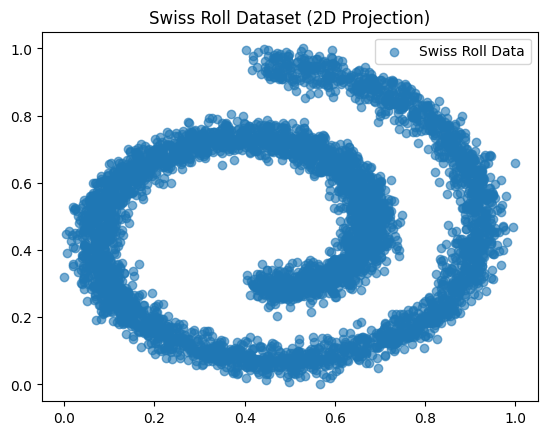

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

def generate_swiss_roll(n_samples=5000, noise=0.7):
    data, _ = make_swiss_roll(n_samples=n_samples, noise=noise)
    data = data[:, [0, 2]]  # Take two dimensions (x, z)
    data = (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))  # Normalize
    return torch.tensor(data, dtype=torch.float32)

x = generate_swiss_roll()

plt.scatter(x[:, 0], x[:, 1], label="Swiss Roll Data", alpha=0.6)
plt.legend()
plt.title("Swiss Roll Dataset (2D Projection)")
plt.show()



### Variance schedule for forward diffusion process

```python
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1.0 - betas
alpha_hats = torch.cumprod(alphas, dim=0)
```

1. betas:  
   - control the amount of noise added at each diffusion step $t$.  
   - In many implementations, $\beta_t$ is chosen to linearly increase (as here, from $1\times10^{-4}$ to 0.02 over $T$ steps), or it may follow a different schedule (e.g., cosine schedule, quadratic, etc.).
2. alphas:  
   - Defined as $\alpha_t = 1 - \beta_t$.  
   - They represent the fraction of the signal retained when noise is added at step \(t\).
3. alpha_hats $\bar{\alpha}_t$:  
   - This is the cumulative product of all $\alpha_s$ up to step $t$:  
     \begin{align}
     \bar{\alpha}_t = \prod_{s=1}^t \alpha_s = \prod_{s=1}^t (1 - \beta_s)
     \end{align}
   - Tells how much of the “original” signal (before noise) remains after \(t\) steps of the forward process. In the DDPM equations, it shows up in the mean and variance terms when sampling or when re-parameterizing the noise.

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Number of diffusion steps
T = 100
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1.0 - betas
alpha_hats = torch.cumprod(alphas, dim=0)  # \bar{\alpha}_t = prod_{s=1..t} (1 - \beta_s)


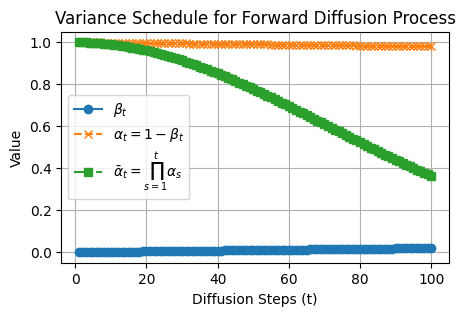

In [34]:
# Plot betas, alphas, and alpha_hats
plt.figure(figsize=(5, 3))
plt.plot(range(1, T+1), betas, label=r'$\beta_t$', linestyle='-', marker='o')
plt.plot(range(1, T+1), alphas, label=r'$\alpha_t = 1 - \beta_t$', linestyle='--', marker='x')
plt.plot(range(1, T+1), alpha_hats, label=r'$\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$', linestyle='-.', marker='s')

plt.xlabel("Diffusion Steps (t)")
plt.ylabel("Value")
plt.title("Variance Schedule for Forward Diffusion Process")
plt.legend()
plt.grid(True)
plt.show()

### Add noise to $x_t$
\begin{align}
x_t = \sqrt{\bar{\alpha_t}} x_0 + \sqrt{1 - \bar{\alpha_t}} \epsilon
\end{align}
where:

- $\bar{\alpha}_t$ is $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$, with $\alpha_s = (1-\beta_s)$.  
- $\epsilon$ is Gaussian noise.  
- In the code,
  - `sqrt_alpha_hat_t` corresponds to $\sqrt{\bar{\alpha_t}}$,  
  - `one_minus_sqrt_alpha_hat_t` corresponds to $\sqrt{1 - \bar{\alpha_t}}$,  
  - `eps` corresponds to the random noise $\epsilon$.  

In [35]:
def get_index_from_list(values, t, x_shape):
    """
    Utility to gather parameters for each sample in a batch.
    values: a 1-D array or list of length T.
    t: a batch of time steps in [0, T-1].
    x_shape: the shape of the data (batch_size, data_dim).
    """
    batch_size = t.shape[0]
    out = values.gather(-1, t).reshape(batch_size, *((1,) * (len(x_shape) - 1)))
    return out

def q_sample(x0, t):
    """
    Forward diffusion: q(x_t | x_0).
    x0: original data, shape (batch_size, data_dim).
    t: time steps for each sample, shape (batch_size,).
    """
    # \bar{\alpha}_t
    sqrt_alpha_hat_t = get_index_from_list(alpha_hats.sqrt(), t, x0.shape)
    # 1 - \bar{\alpha}_t
    one_minus_sqrt_alpha_hat_t = get_index_from_list((1 - alpha_hats).sqrt(), t, x0.shape)
    # Sample noise
    eps = torch.randn_like(x0)
    # x_t = sqrt_bar_alpha_t * x0 + sqrt(1 - bar_alpha_t) * eps
    return sqrt_alpha_hat_t * x0 + one_minus_sqrt_alpha_hat_t * eps


### torch.gather()
Best explanation: https://stackoverflow.com/questions/50999977/what-does-gather-do-in-pytorch-in-layman-terms
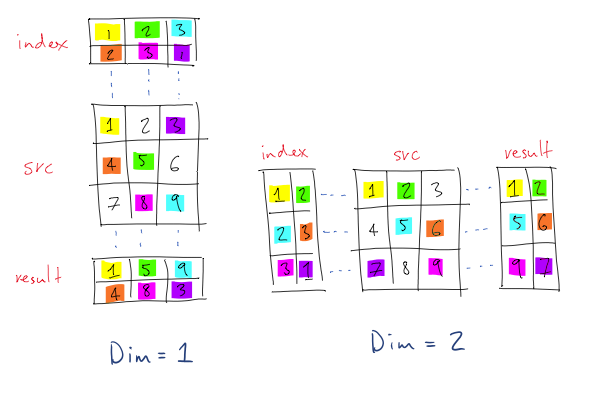

In [36]:
class TimeEmbedding(nn.Module):
    """
    Embeds a scalar time step t into a higher-dimensional vector using
    sinusoidal embeddings (similar to positional embeddings in Transformers).
    """
    def __init__(self, dim=32):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        """
        Args:
            t (Tensor): shape (batch_size,) of integer time steps.

        Returns:
            emb (Tensor): shape (batch_size, dim). Sinusoidal time embeddings.

        Explanation:
            - We map each time step to a combination of sin/cos functions at different frequencies.
            - This helps the model learn how to condition on t more smoothly.
        """
        half_dim = self.dim // 2
        emb_factor = math.log(10000) / (half_dim - 1)
        emb_scale = torch.exp(torch.arange(half_dim, device=t.device) * -emb_factor)
        emb = t.unsqueeze(1).float() * emb_scale.unsqueeze(0)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)  # (batch_size, dim)
        return emb

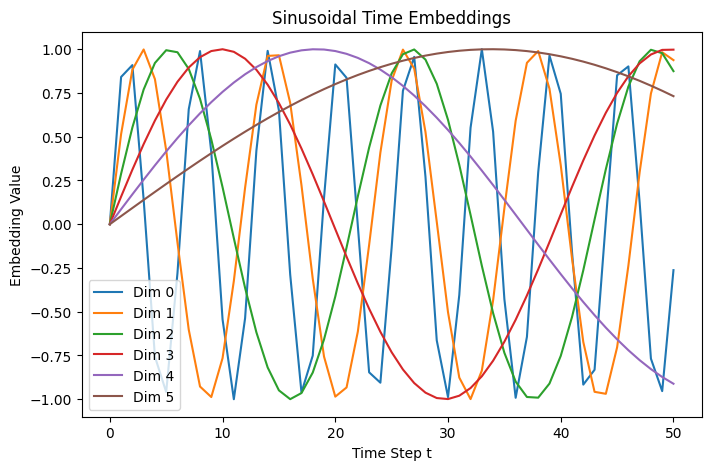

In [37]:
def plot_time_embeddings(embed_dim=32, max_t=50, show_dims=6):
    """
    Args:
        embed_dim (int): Total embedding dimension (must be even).
        max_t (int): We will plot embeddings for t in [0, max_t].
        show_dims (int): Number of embedding dimensions to plot.

    Explanation:
        - We generate time steps from 0 to max_t.
        - Compute embeddings for each t.
        - Plot a few of the embedding dimensions vs. t.
    """
    time_embed = TimeEmbedding(dim=embed_dim)
    times = torch.arange(max_t+1)

    # Get embeddings => shape (max_t+1, embed_dim)
    with torch.no_grad():
        embs = time_embed(times)

    plt.figure(figsize=(8, 5))
    for d in range(show_dims): # plot a few dimension
        plt.plot(times.numpy(), embs[:, d].numpy(), label=f"Dim {d}")

    plt.title("Sinusoidal Time Embeddings")
    plt.xlabel("Time Step t")
    plt.ylabel("Embedding Value")
    plt.legend()
    plt.show()


# Example usage
plot_time_embeddings(embed_dim=32, max_t=50, show_dims=6)

In [38]:
class MLPDiffusion(nn.Module):
    def __init__(self, in_dim=2, time_emb_dim=32, hidden_dim=128):
        super().__init__()
        self.time_emb = TimeEmbedding(time_emb_dim)

        self.net = nn.Sequential(
            nn.Linear(in_dim + time_emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_dim)
        )

    def forward(self, x, t):
        """
        x: shape (batch_size, 2)
        t: shape (batch_size,) time steps
        """
        te = self.time_emb(t)  # shape (batch_size, time_emb_dim)
        inp = torch.cat([x, te], dim=-1)
        return self.net(inp)


### Noise
\begin{align}
\epsilon
&= \frac{x_{\text{noisy}} - \sqrt{\bar{\alpha}_t}\, x_0}
         {\sqrt{1 - \bar{\alpha}_t}}
\end{align}
Loss is squared difference between actual noise and predicted noise

In [39]:
def train_diffusion_model(model, data, n_epochs=1000, batch_size=256, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    data = data.to(device)
    dataset = torch.utils.data.TensorDataset(data)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()

    for epoch in range(n_epochs):
        total_loss = 0
        for batch in dataloader:
            x0 = batch[0]  # shape (batch_size, 2)
            # Random t in [0, T-1], random t for each data in batch
            t = torch.randint(0, T, (x0.shape[0],), device=device).long()

            # Forward diffusion: x_t
            x_noisy = q_sample(x0, t) # noisy sample at step t
            # The actual noise added in the forward process
            eps = (x_noisy - get_index_from_list(alpha_hats.sqrt(), t, x_noisy.shape)*x0) \
                  / get_index_from_list((1 - alpha_hats).sqrt(), t, x_noisy.shape) # x_noisy = sqrt_alpha_hat_t * x0 + one_minus_sqrt_alpha_hat_t * eps

            # Predict noise
            eps_pred = model(x_noisy, t)

            loss = loss_fn(eps_pred, eps)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x0.shape[0] # loss.item() gives average loss

        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {total_loss/len(dataset):.6f}")


### Generate value from noise predicted
Fuction p_sample() denoise: $x_{t-1}=p_\theta(x_{t-1} \mid x_t)$

1. Parameters at the current time step $t$:
   - $\beta_t$ (from `betas_t`)
   - $\alpha_t$ (from `alpha_t = 1 - \beta_t`)
   - $\bar{\alpha}_t$ (from `alpha_hat_t`, the product of $\alpha_s$ terms up to $t$)  
   These quantities determine how much noise is to be removed.

2. Predict the noise with the model $\epsilon_\theta$:  
   \begin{align}
   \epsilon_\theta(x_t, t) \quad\longleftarrow\quad \text{`model(x, t)`}
   \end{align}

3. Compute the mean of the posterior $x_{t-1}$ given $x_t$.
   ```python
   mean = (1 / sqrt(alpha_t)) * [ x_t - (beta_t / sqrt(1 - alpha_hat_t)) * eps_theta ]
   ```  
   which is derived from the DDPM reverse update equation:

   \begin{align}
   x_{t-1}
   = \frac{1}{\sqrt{\alpha_t}}\Bigl(x_t
       - \frac{1-\alpha_t}{\sqrt{1 - \bar{\alpha}_t}}\,\epsilon_\theta(x_t,t)\Bigr)
   \quad(\text{plus a noise term if } t>0).
   \end{align}

4. Add noise if $t>0$: When $t>0$, we inject Gaussian noise scaled by $\sigma_t = \sqrt{\beta_t}$. This is the variance component in the reverse diffusion step. If $t=0$, no further noise is added, meaning $x_0$ is fully determined.
\begin{align}
x_{t-1} \sim \text{N}\Bigl(\mu_\theta(x_t, t),\;\sigma_t^2 \mathbf{I}\Bigr)
\end{align}

In [40]:
@torch.no_grad()
def p_sample(model, x, t):
    """
    One reverse sampling step:
    p_theta(x_{t-1} | x_t).
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alpha_t = get_index_from_list((1 - alphas).sqrt(), t, x.shape)
    alpha_t = get_index_from_list(alphas, t, x.shape)
    alpha_hat_t = get_index_from_list(alpha_hats, t, x.shape)

    # Model predicts noise
    eps_theta = model(x, t)

    # Equation: x_{t-1} = 1/sqrt(alpha_t) * (x_t - (1-alpha_t)/sqrt(1-alpha_hat_t) * eps_theta) + ...
    # The final "..." is the variance term. We'll take the "posterior variance" or simplified variance for sampling.
    # For t > 0, we add noise. For t=0, no noise is added (since x_0 is fully determined).

    mean = (1.0 / alpha_t.sqrt()) * (x - betas_t / sqrt_one_minus_alpha_t * eps_theta)
    if t[0] > 0:
        # Add noise
        z = torch.randn_like(x)
        sigma_t = betas_t.sqrt()
        return mean + sigma_t * z # add noise to not be deterministic
    else:
        return mean

@torch.no_grad()
def p_sample_loop(model, shape):
    """
    Iteratively sample x_{T-1}, x_{T-2}, ..., x_0.
    shape: (batch_size, 2) for 2D data.
    """
    b = shape[0]
    # Start from pure Gaussian noise
    x = torch.randn(shape, device=device)

    for i in reversed(range(T)):
        # [i] as tensor
        t = (torch.ones(b) * i).long().to(device)
        x = p_sample(model, x, t)
    return x

def sample_new_data(model, n_samples=500):
    model.eval()
    samples = p_sample_loop(model, (n_samples, 2))
    return samples.cpu().numpy()


Epoch [1/1000], Loss: 0.903515
Epoch [100/1000], Loss: 0.322771
Epoch [200/1000], Loss: 0.309298
Epoch [300/1000], Loss: 0.289984
Epoch [400/1000], Loss: 0.298653
Epoch [500/1000], Loss: 0.306568
Epoch [600/1000], Loss: 0.297036
Epoch [700/1000], Loss: 0.293872
Epoch [800/1000], Loss: 0.299046
Epoch [900/1000], Loss: 0.289014
Epoch [1000/1000], Loss: 0.280685


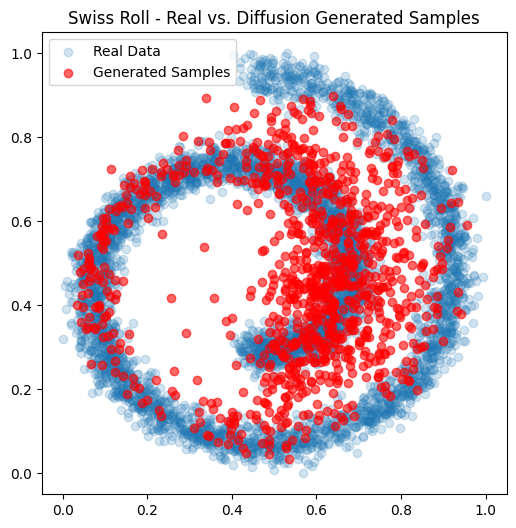

In [41]:
# 1. Define model and move to device
model = MLPDiffusion().to(device)

# 2. Train
train_diffusion_model(model, x, n_epochs=1000, batch_size=256, lr=1e-3)

# 3. Sample new data
generated_samples = sample_new_data(model, n_samples=1000)

# 4. Visualize
plt.figure(figsize=(6,6))
plt.scatter(x[:, 0], x[:, 1], label="Real Data", alpha=0.2)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], label="Generated Samples", alpha=0.6, c='r')
plt.legend()
plt.title("Swiss Roll - Real vs. Diffusion Generated Samples")
plt.show()

## Deterministic Generation

In [42]:
@torch.no_grad()
def p_sample(model, x, t):
    """
    One reverse sampling step:
    p_theta(x_{t-1} | x_t).
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alpha_t = get_index_from_list((1 - alphas).sqrt(), t, x.shape)
    alpha_t = get_index_from_list(alphas, t, x.shape)
    alpha_hat_t = get_index_from_list(alpha_hats, t, x.shape)

    # Model predicts noise
    eps_theta = model(x, t)

    # Equation: x_{t-1} = 1/sqrt(alpha_t) * (x_t - (1-alpha_t)/sqrt(1-alpha_hat_t) * eps_theta) + ...
    # The final "..." is the variance term. We'll take the "posterior variance" or simplified variance for sampling.
    # For t > 0, we add noise. For t=0, no noise is added (since x_0 is fully determined).

    mean = (1.0 / alpha_t.sqrt()) * (x - betas_t / sqrt_one_minus_alpha_t * eps_theta)
    # if t[0] > 0:
    #     # Add noise
    #     z = torch.randn_like(x)
    #     sigma_t = betas_t.sqrt()
    #     return mean + sigma_t * z # add noise to not be deterministic
    # else:
    #     return mean
    return mean

@torch.no_grad()
def p_sample_loop(model, shape):
    """
    Iteratively sample x_{T-1}, x_{T-2}, ..., x_0.
    shape: (batch_size, 2) for 2D data.
    """
    b = shape[0]
    # Start from pure Gaussian noise
    x = torch.randn(shape, device=device)

    for i in reversed(range(T)):
        # [i] as tensor
        t = (torch.ones(b) * i).long().to(device)
        x = p_sample(model, x, t)
    return x

def sample_new_data(model, n_samples=500):
    model.eval()
    samples = p_sample_loop(model, (n_samples, 2))
    return samples.cpu().numpy()

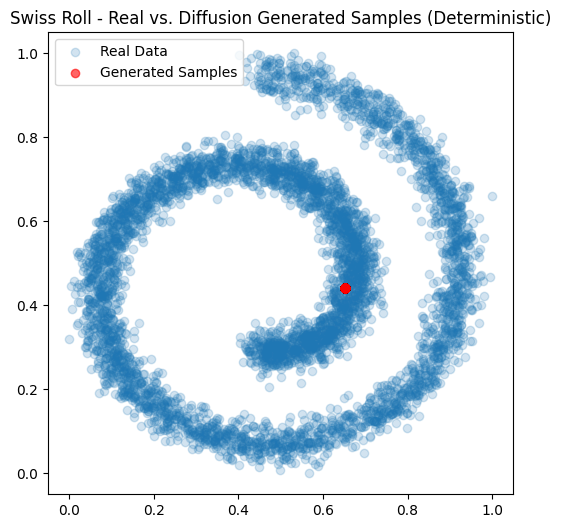

In [43]:
# 3. Sample new data
generated_samples = sample_new_data(model, n_samples=1000)

# 4. Visualize
plt.figure(figsize=(6,6))
plt.scatter(x[:, 0], x[:, 1], label="Real Data", alpha=0.2)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], label="Generated Samples", alpha=0.6, c='r')
plt.legend()
plt.title("Swiss Roll - Real vs. Diffusion Generated Samples (Deterministic)")
plt.show()